# **Data Science for Innovation Project**
## Facial Expression Recognition

### **Import necessary libraries and frameworks**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### **Import dataset**

In [3]:
test_dir = '/kaggle/input/fer2013/test'
train_dir = '/kaggle/input/fer2013/train'

In [4]:
emotions = os.listdir(train_dir)
emotions

['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

***Above is the 7 different output categories in the train_dir***

### **Data Visualization**

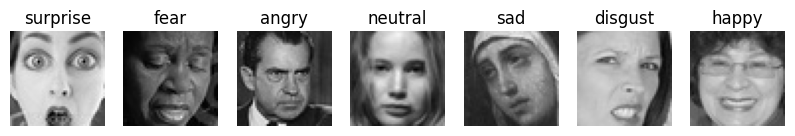

In [5]:
i = 1
plt.figure(figsize=(10, 10))
for emotion in emotions:
    img_dir = os.listdir(f'{train_dir}/{emotion}')[1]
    image = f'{train_dir}/{emotion}/{img_dir}'
    img = load_img(image)
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis('off')
    i += 1
    
plt.show()

***Here is the plot of each photo and their expression output label***

In [6]:
count_labels_train_valid = dict()
for emotion in emotions:
    counter = len(os.listdir (f'{train_dir}/{emotion}'))
    count_labels_train_valid[f'{emotion}'] = counter
train_count_df = pd.DataFrame (list (count_labels_train_valid.items()), columns = ['category', 'count'])
train_count_df

,category,count
0,surprise,3171
1,fear,4097
2,angry,3995
3,neutral,4965
4,sad,4830
5,disgust,436
6,happy,7215


***Total values of each categories in the train dataset***

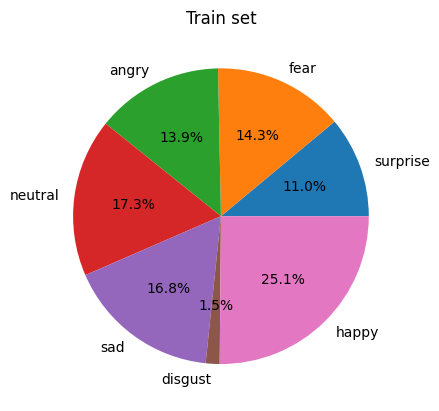

In [7]:
plt.pie(data = train_count_df, x = 'count', labels = 'category', autopct='%1.1f%%')
plt.title ('Train set')
plt.show()

***Distribution of values across each category in the train dataset***

In [8]:
count_labels_test = dict()
for emotion in emotions:
    counter = len(os.listdir (f'{test_dir}/{emotion}'))
    count_labels_test[f'{emotion}'] = counter
test_count_df = pd.DataFrame (list (count_labels_test.items()), columns = ['category', 'count'])
test_count_df

,category,count
0,surprise,831
1,fear,1024
2,angry,958
3,neutral,1233
4,sad,1247
5,disgust,111
6,happy,1774


***Total values of each categories in the test dataset***

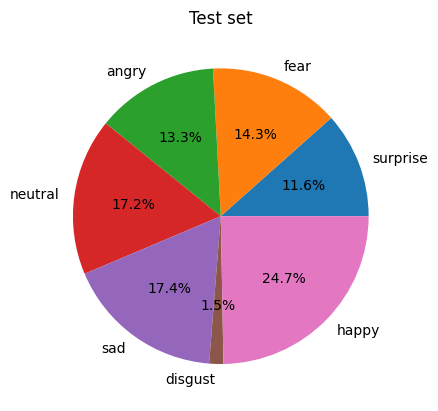

In [9]:
plt.pie(data = test_count_df, x = 'count', labels = 'category', autopct='%1.1f%%')
plt.title ('Test set')
plt.show()

***Distribution of values across each category in the train dataset***

### **Exploratory Data Analysis (EDA)**

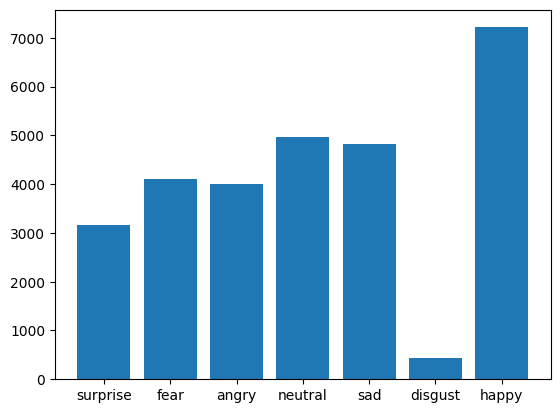

In [10]:
def eda(info):
    labels = list(info.keys())
    count_ = list(info.values())
    plt.bar (labels, count_)
    plt.show()
eda(count_labels_train_valid)

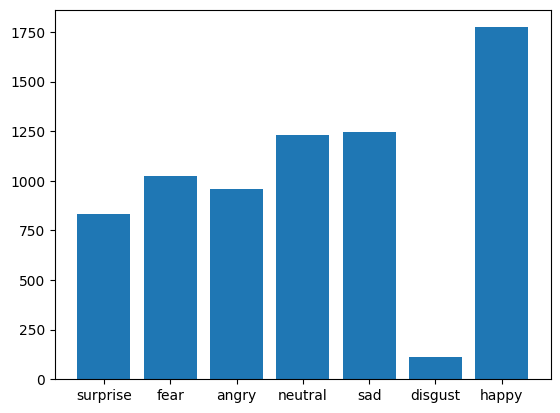

In [11]:
eda(count_labels_test)

***The distribution of output attributes is unbalanced when the number of 'happy' categories is disproportionately high compared to the number of 'disgust' categories.***

### **Data Pre-processing**

**As shown in the graph above, the number of 'disgust' attribute is extremely lower than the other categories. Therefore, our job is to generate more data in this particular category.**

In [13]:
target_dir = f'{train_dir}/disgust'
disgust_aug_X = []
disgust_aug_Y = []
for img in tqdm (os.listdir (target_dir)):
    file = img.split ('.')[0]
    image = load_img (f'{target_dir}/{img}')
    image = img_to_array (image)
    data = np.expand_dims(image, 0)
    
    img_gen = ImageDataGenerator (horizontal_flip = True, rotation_range = 45)
    ## The image generation includes horizontal flip and image rotation within the range of 45 degree
    gen = img_gen.flow(data, batch_size = 1)
    for i in range (8):
        batch_ = gen.next()
        image = batch_[0].astype ('uint8')
        image.reshape((48, 48, 3))
        image = rgb_to_grayscale (image)
        image = image[:, :, 0]
        disgust_aug_X.append (np.array (image).reshape (48, 48, 1))
        disgust_aug_Y.append ([0, 1, 0, 0, 0, 0, 0])

100%|██████████| 436/436 [00:13<00:00, 31.58it/s]


***This above code performs data augmentation on the "disgust" class images, generating variants of these images by applying horizontal flips and rotations, and accumulating the augmented data along with labels in lists.***

******

In [11]:
disgust_aug_X = np.array (disgust_aug_X)
disgust_aug_X.shape

(3488, 48, 48, 1)

***This is the shape of the 'disgust' feature after the data augmentation step***

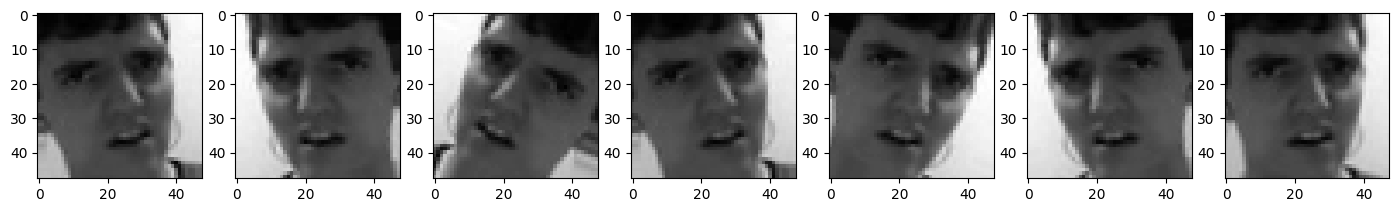

In [12]:
j = 1
plt.figure(figsize = (20 , 20))
for i in range (181, 188):
    plt.subplot (i)
    plt.imshow (disgust_aug_X[j], cmap = 'gray')
    j+= 1

***The plot describes the variation of a photo in the disgust class after passing through the pre-processing step.***

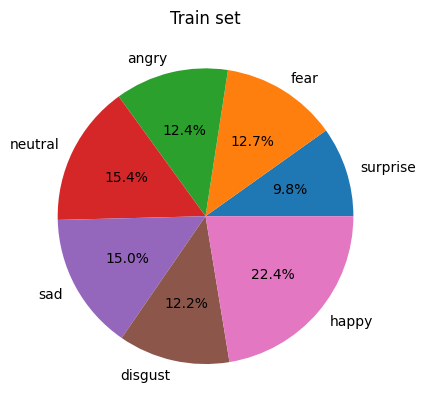

In [16]:
count_labels_train_valid['disgust'] = count_labels_train_valid['disgust'] + disgust_aug_X.shape[0]

count_labels_train_valid = pd.DataFrame (list (count_labels_train_valid.items()), columns = ['category', 'count'])
plt.pie(data = count_labels_train_valid, x = 'count', labels = 'category', autopct='%1.1f%%')
plt.title ('Train set')
plt.show()

***The bar chart above show the balanced distribution of the data***

In [18]:
batch_size = 64
img_height = 48
img_width = 48

In [19]:
train_ds = tf.keras.utils. kì image_dataset_from_directory(
    directory = train_dir,
    labels = 'inferred',
    validation_split = 0.2,
    subset = 'training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_dir,
    labels = 'inferred',
    validation_split = 0.2,
    subset = 'validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = test_dir,
    labels = 'inferred',
    seed=123,
    image_size=(img_height, img_width),
    #batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


***The code above use the function 'utils.image_dataset_from_directory' from Tensorflow to create datasets for training, validation, and testing from image directories***

In [20]:
from sklearn.model_selection import train_test_split
disgust_aug_X_train, disgust_aug_X_val, disgust_aug_Y_train, disgust_aug_Y_val = train_test_split (disgust_aug_X, disgust_aug_Y, test_size = 0.2, random_state = 42)

***The train data is split into 4 variables where x_train and y_train are feature and label data for training the model and x_valid and y_valid are feature and label data for validation process which is assessing the performances and make adjustments needed.***

In [23]:
#unzipping data and labels -> separate them into different arrays + adding augmented data
trainX, trainY = zip(*train_ds)
valX, valY = zip (*val_ds)
testX, testY = zip(*test_ds)

trainX = np.concatenate([x for x in trainX], axis = 0)
trainX = np.concatenate ([trainX, disgust_aug_X_train], axis = 0)
trainY = np.concatenate([y for y in trainY], axis = 0)
trainY = np.concatenate ([trainY, disgust_aug_Y_train], axis = 0)

valX = np.concatenate([x for x in valX], axis = 0)
valX = np.concatenate ([valX, disgust_aug_X_val], axis = 0)
valY = np.concatenate([y for y in valY], axis = 0)
valY = np.concatenate ([valY, disgust_aug_Y_yo val], axis = 0)

testX = np.concatenate([x for x in testX], axis = 0)
testY = np.concatenate([y for y in testY], axis = 0)


***Now, we are going to unzip the data and labels from your datasets and then adding augmented data to your training and validation sets. Typically, these data arrays are used to train and evaluate machine learning and deep learning models. The augmented data is added to the training and validation sets to enhance the performance and robustness of the model by increasing the diversity of the training data.*** 

******

In [22]:
print ('Dataset Dimensions')
print (f'Train Dataset. Training attributes: {trainX.shape}, Labels: {trainY.shape}')
print (f'Validation Dataset. Training attributes: {valX.shape}, Labels: {valY.shape}')
print (f'Test Dataset. Training attributes: {testX.shape}, Labels: {testY.shape}')

Dataset Dimensions
Train Dataset. Training attributes: (25758, 48, 48, 1), Labels: (25758, 7)
Validation Dataset. Training attributes: (6439, 48, 48, 1), Labels: (6439, 7)
Test Dataset. Training attributes: (7178, 48, 48, 1), Labels: (7178, 7)
